In [1]:
import sys
sys.path.insert(0, '../../')

import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm import trange
from skimage.filters import threshold_li

from gasp import responses, gasp as GASP, get_project_path

In [2]:
path = get_project_path()
filepath = os.path.join(path, 'data', 'gasp_data.npy')
data = np.load(filepath)
print(data.shape) # [Height, Width, Coil, Avg, PCs, TRs]

(512, 256, 4, 16, 3)


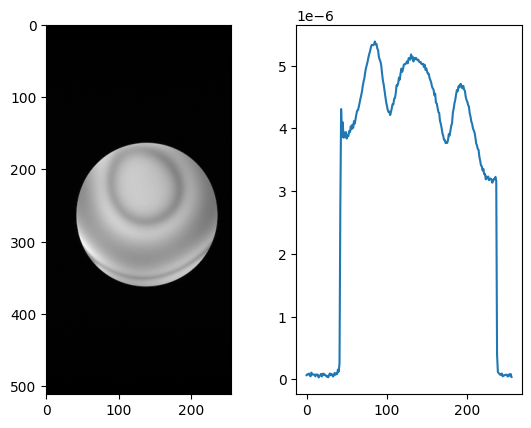

In [3]:
_ = np.sqrt(np.sum(np.abs(data)**2, axis=2))
_ = abs(_[:,:,0,0])
xx, yy = _.shape[:2]

plt.subplot(1, 2, 1)
plt.imshow(_, cmap='gray')
plt.subplot(1, 2, 2)
plt.plot(_[int(xx/2), :])
plt.show()

In [ ]:
# Create mask of phantom
_ = np.sqrt(np.sum(np.abs(data)**2, axis=2))
_ = np.mean(_, axis=2)
_ = np.mean(_, axis=2)
_ = abs(_)
thresh = threshold_li(_)
mask = np.abs(_) > thresh
print(mask.shape)

# Apply mask to data
mask0 = np.tile(
    mask, (data.shape[2:] + (1, 1,))).transpose((3, 4, 0, 1, 2))
data = data * mask0

print(data.shape[:-2])
data = np.reshape(data, data.shape[:-2] + (-1,))    # [Height, Width, Coil, PCs x TRs]
data = np.moveaxis(data, 2, 0)                      # [Coil, Height, Width, PCs x TRs]
data = data.transpose((0, 3, 2, 1))                 # [Coil,  PCs x TRs, Width,   Height]

# Get new dimensions
ncoils, npcs, height, width = data.shape[:]
print(data.shape)

(512, 256)
(512, 256, 4)
(4, 48, 256, 512)


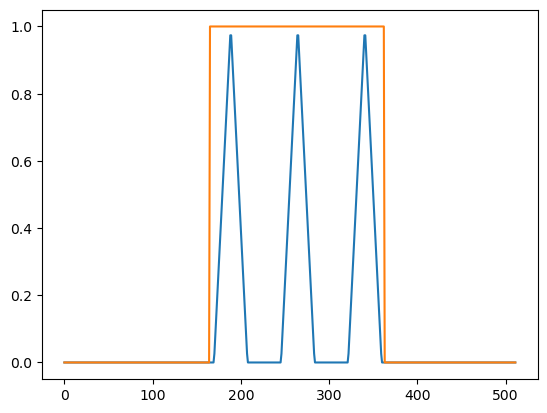

In [ ]:
# Calibration box - (# Number of lines of calibration, Pixels on signal)
C_dim = (32, width)

D = responses.triangle_periodic(width, 76, 18, 38)
D *= mask.T[int(height/2), :]
plt.plot(D)
plt.plot(mask[:,128])
plt.show()

TypeError: Invalid shape (48, 256, 512) for image data

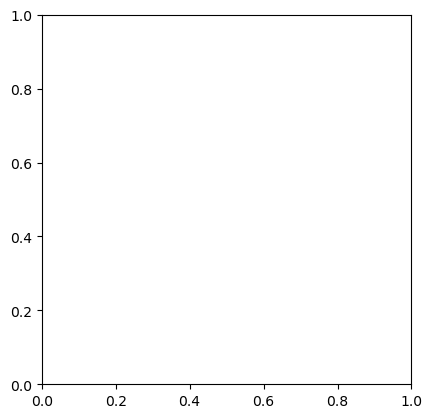

In [ ]:
W = width
bandpass = np.zeros(data.shape[1:])
bandpass[:, 3*W//8:5*W//8] = 1
plt.imshow(bandpass)
plt.show()

In [ ]:
D[169]

0.0

In [ ]:
D[359]

0.02631578947368421

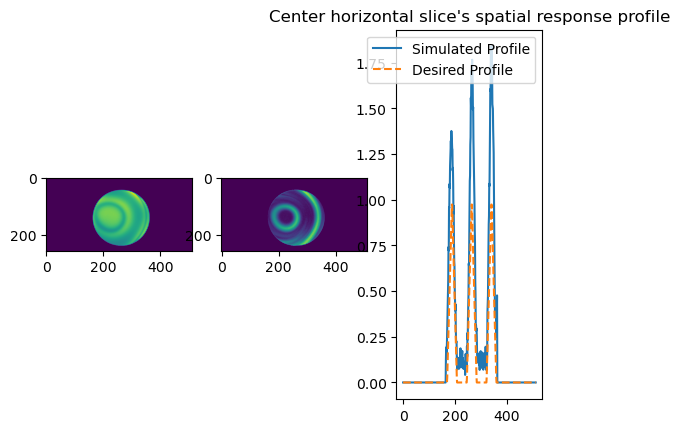

In [ ]:
Ic = np.zeros((ncoils, height, width), dtype='complex')
for cc in trange(ncoils, leave=False):
    Ic[cc, ...] = GASP.gasp(data[cc, ...], D, C_dim, pc_dim=0)
Ic = np.sqrt(np.sum(np.abs(Ic)**2, axis=0))

plt.subplot(1, 3, 1)
plt.imshow(np.sqrt(np.sum(abs(data[:, 0, ...])**2, axis=0)))

plt.subplot(1, 3, 2)
plt.imshow(Ic)

plt.subplot(1, 3, 3)
plt.plot(np.abs(Ic[int(height/2), :]), label='Simulated Profile')
plt.plot(D, '--', label='Desired Profile')
plt.legend()
plt.title('Center horizontal slice\'s spatial response profile')
plt.show()